In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.morphology as skimage_morphology
from skimage.graph import route_through_array
import pandas as pd

In [23]:
def process_image(img_save_path):
    img_ref_rgb = cv2.imread(img_save_path)
    img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 10, 255, cv2.THRESH_BINARY)
    img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    
    return img_ref_binary

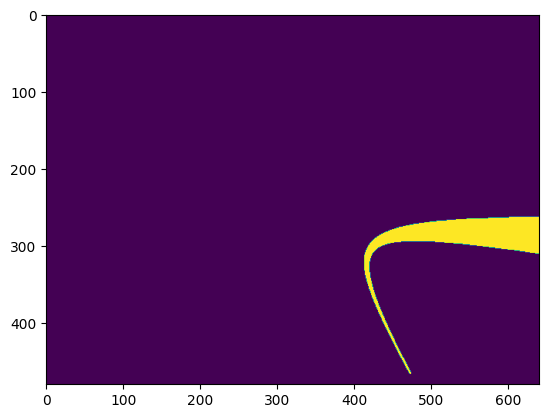

In [24]:
scripts_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2'
dataset_folder = "gt_dataset4"
# gt_name = 'gt_2_-0.0012_-0.0010_0.2_0.01'
# gt_name = 'gt_23_-0.0010_0.0008_0.2_0.01'
gt_name = 'gt_120_0.0006_0.0010_0.2_0.01'



case_naming = scripts_path + '/' + dataset_folder + '/' + gt_name
img_save_path = case_naming + '.png'
cc_specs_path = case_naming + '.npy'

img_ref_binary = process_image(img_save_path)
plt.figure(1)
plt.imshow(img_ref_binary)

Old version of get_raw_centerline() in loss_define.py and construction_bezier.py

The coordinates of the obtained skeleton are not sequential

(480, 700)


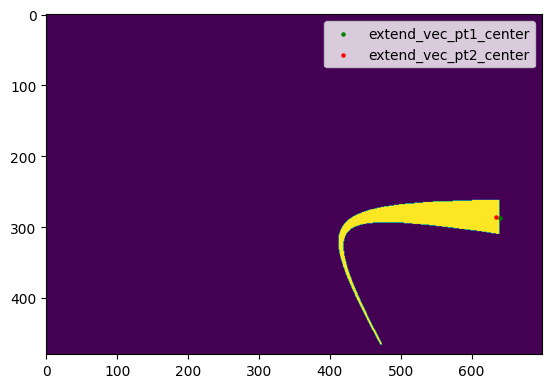

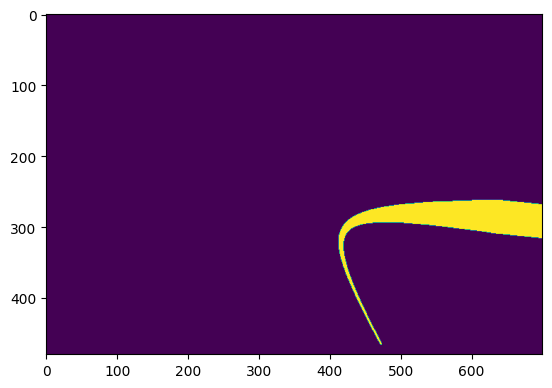

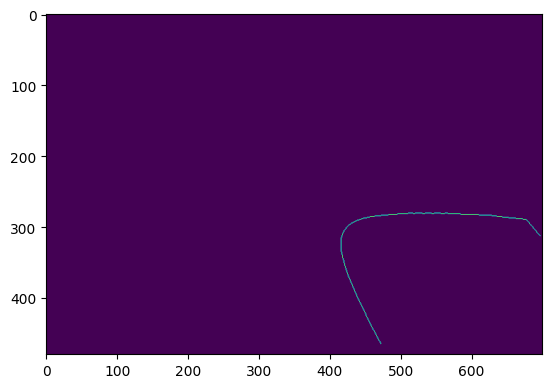

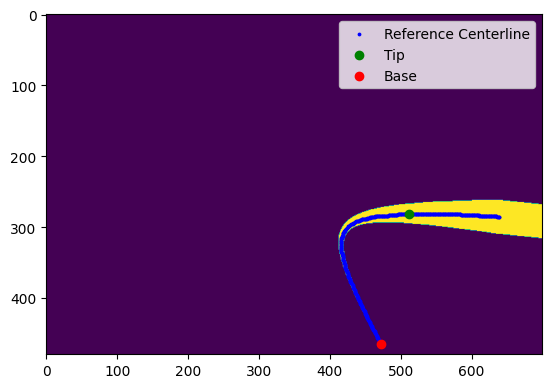

In [25]:
img_ref = img_ref_binary

img_height = img_ref.shape[0]
img_width = img_ref.shape[1]

# perform skeletonization, need to extend the boundary of the image because of the way the skeletonization algorithm works (it looks at the 8 neighbors of each pixel)
extend_dim = int(60)
img_thresh_extend = np.zeros((img_height, img_width + extend_dim))
img_thresh_extend[0:img_height, 0:img_width] = img_ref / 1.0

# get the left boundary of the image
left_boundarylineA_id = np.squeeze(np.argwhere(img_thresh_extend[:, img_width - 1]))
left_boundarylineB_id = np.squeeze(np.argwhere(img_thresh_extend[:, img_width - 10]))

# get the center of the left boundary
extend_vec_pt1_center = np.array([img_width, (left_boundarylineA_id[0] + left_boundarylineA_id[-1]) / 2])
extend_vec_pt2_center = np.array(
    [img_width - 5, (left_boundarylineB_id[0] + left_boundarylineB_id[-1]) / 2])
exten_vec = extend_vec_pt2_center - extend_vec_pt1_center

plt.figure()
plt.imshow(img_thresh_extend)
plt.scatter(extend_vec_pt1_center[0], extend_vec_pt1_center[1], color='green', label='extend_vec_pt1_center', s=5)  
plt.scatter(extend_vec_pt2_center[0], extend_vec_pt2_center[1], color='red', label='extend_vec_pt2_center', s=5)
plt.legend()

# avoid dividing by zero
if exten_vec[1] == 0:
    exten_vec[1] += 0.00000001

# get the slope and intercept of the line
k_extend = exten_vec[0] / exten_vec[1]
b_extend_up = img_width - k_extend * left_boundarylineA_id[0]
b_extend_dw = img_width - k_extend * left_boundarylineA_id[-1]

# extend the ROI to the right, so that the skeletonization algorithm could be able to get the centerline
# then it could be able to get the intersection point with boundary
extend_ROI = np.array([
    np.array([img_width, left_boundarylineA_id[0]]),
    np.array([img_width, left_boundarylineA_id[-1]]),
    np.array([img_width + extend_dim,
                int(((img_width + extend_dim) - b_extend_dw) / k_extend)]),
    np.array([img_width + extend_dim,
                int(((img_width + extend_dim) - b_extend_up) / k_extend)])
])

# fill the extended ROI with 1
img_thresh_extend = cv2.fillPoly(img_thresh_extend, [extend_ROI], 1)

plt.figure()
plt.imshow(img_thresh_extend)

# skeletonize the image
skeleton = skimage_morphology.skeletonize(img_thresh_extend)
print(skeleton.shape)

plt.figure()
plt.imshow(skeleton)

# get the centerline of the image
img_raw_skeleton = np.argwhere(skeleton[:, 0:img_width] == 1)

plt.figure()
plt.imshow(img_thresh_extend)
img_raw_skeleton = img_raw_skeleton[:, [1, 0]]
x_centerline = img_raw_skeleton[:, 0]
y_centerline = img_raw_skeleton[:, 1]
tip_coords = img_raw_skeleton[0, :].astype(int)
base_coords = img_raw_skeleton[-1, :].astype(int)
plt.scatter(x_centerline, y_centerline, c='b', s=3, label='Reference Centerline')
plt.scatter(tip_coords[0], tip_coords[1], color='green', label='Tip')  
plt.scatter(base_coords[0], base_coords[1], color='red', label='Base')
plt.legend()

New version of get_raw_centerline()

Designed algorithm to find the tip and base among skeleton points.

In [26]:
# img_ref = img_ref_binary

# img_height = img_ref.shape[0]
# img_width = img_ref.shape[1]

# # perform skeletonization, need to extend the boundary of the image because of the way the skeletonization algorithm works (it looks at the 8 neighbors of each pixel)
# extend_dim = int(60)
# img_thresh_extend = np.zeros((img_height, img_width + extend_dim))
# img_thresh_extend[0:img_height, 0:img_width] = img_ref / 1.0

# # get the left boundary of the image
# left_boundarylineA_id = np.squeeze(np.argwhere(img_thresh_extend[:, img_width - 1]))
# left_boundarylineB_id = np.squeeze(np.argwhere(img_thresh_extend[:, img_width - 10]))

# # get the center of the left boundary
# extend_vec_pt1_center = np.array([img_width, (left_boundarylineA_id[0] + left_boundarylineA_id[-1]) / 2])
# extend_vec_pt2_center = np.array(
#     [img_width - 5, (left_boundarylineB_id[0] + left_boundarylineB_id[-1]) / 2])
# exten_vec = extend_vec_pt2_center - extend_vec_pt1_center

# plt.figure()
# plt.imshow(img_thresh_extend)
# plt.scatter(extend_vec_pt1_center[0], extend_vec_pt1_center[1], color='green', label='extend_vec_pt1_center', s=5)  
# plt.scatter(extend_vec_pt2_center[0], extend_vec_pt2_center[1], color='red', label='extend_vec_pt2_center', s=5)
# plt.legend()

# # avoid dividing by zero
# if exten_vec[1] == 0:
#     exten_vec[1] += 0.00000001

# # get the slope and intercept of the line
# k_extend = exten_vec[0] / exten_vec[1]
# b_extend_up = img_width - k_extend * left_boundarylineA_id[0]
# b_extend_dw = img_width - k_extend * left_boundarylineA_id[-1]

# # extend the ROI to the right, so that the skeletonization algorithm could be able to get the centerline
# # then it could be able to get the intersection point with boundary
# extend_ROI = np.array([
#     np.array([img_width, left_boundarylineA_id[0]]),
#     np.array([img_width, left_boundarylineA_id[-1]]),
#     np.array([img_width + extend_dim,
#                 int(((img_width + extend_dim) - b_extend_dw) / k_extend)]),
#     np.array([img_width + extend_dim,
#                 int(((img_width + extend_dim) - b_extend_up) / k_extend)])
# ])

# # fill the extended ROI with 1
# img_thresh_extend = cv2.fillPoly(img_thresh_extend, [extend_ROI], 1)

# plt.figure()
# plt.imshow(img_thresh_extend)

# # skeletonize the image
# skeleton = skimage_morphology.skeletonize(img_thresh_extend)
# skeleton[:, img_width:] = 0
# print(skeleton.shape)

# # # save skeleton to excel
# # df = pd.DataFrame(skeleton)
# # df.to_excel('matrix.xlsx', index=False, header=False)


# plt.figure()
# plt.imshow(skeleton)

# # get the centerline of the image
# img_raw_skeleton = np.argwhere(skeleton[:, 0:img_width] == 1)

# # Find endpoints of the skeleton
# def find_endpoints(skeleton, skeleton_coords):
#     endpoints = []
#     for x, y in skeleton_coords:
#         neighborhood = skeleton[x-1:x+2, y-1:y+2]
#         if np.sum(neighborhood) == 2:  # endpoint will have only one neighbor in the skeleton
#             endpoints.append((x, y))
            
#     if len(endpoints) != 2:
#         raise ValueError("The skeleton does not have exactly two endpoints.")

#     return endpoints

# endpoints = find_endpoints(skeleton, img_raw_skeleton)
# print(len(endpoints))



# # Find path through skeleton from one endpoint to the other
# tip, base = endpoints
# print("tip: ", [tip[1], tip[0]])
# print("base: ", [base[1], base[0]])

# plt.figure()
# plt.imshow(img_thresh_extend)
# img_raw_skeleton = img_raw_skeleton[:, [1, 0]]
# x_centerline = img_raw_skeleton[:, 0]
# y_centerline = img_raw_skeleton[:, 1]
# # tip_coords = img_raw_skeleton[0, :].astype(int)
# # base_coords = img_raw_skeleton[-1, :].astype(int)
# plt.scatter(x_centerline, y_centerline, c='b', s=3, label='Reference Centerline')
# plt.scatter(tip[1], tip[0], color='green', label='Tip')  
# plt.scatter(base[1], base[0], color='red', label='Base')
# plt.legend()

In [27]:
# Find endpoints of the skeleton and their indices
def find_endpoints(skeleton, skeleton_coords):
    endpoints = []
    endpoint_indices = []
    for idx, (x, y) in enumerate(skeleton_coords):
        neighborhood = skeleton[x-1:x+2, y-1:y+2]
        if np.sum(neighborhood) == 2:  # endpoint will have only one neighbor in the skeleton
            endpoints.append((x, y))
            endpoint_indices.append(idx)

    if len(endpoints) != 2:
        raise ValueError("The skeleton does not have exactly two endpoints.")

    # Determine tip and base based on y-coordinate
    if endpoints[0][1] < endpoints[1][1]:
        tip, base = endpoints[0], endpoints[1]
        tip_idx, base_idx = endpoint_indices[0], endpoint_indices[1]
    else:
        tip, base = endpoints[1], endpoints[0]
        tip_idx, base_idx = endpoint_indices[1], endpoint_indices[0]

    # Swap tip with the first element and base with the last element
    skeleton_coords[0], skeleton_coords[tip_idx] = skeleton_coords[tip_idx], skeleton_coords[0]
    skeleton_coords[-1], skeleton_coords[base_idx] = skeleton_coords[base_idx], skeleton_coords[-1]

    return skeleton_coords

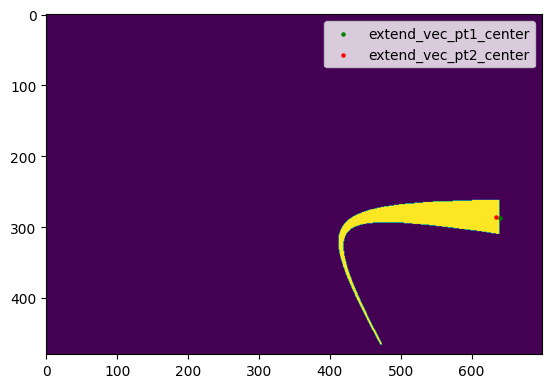

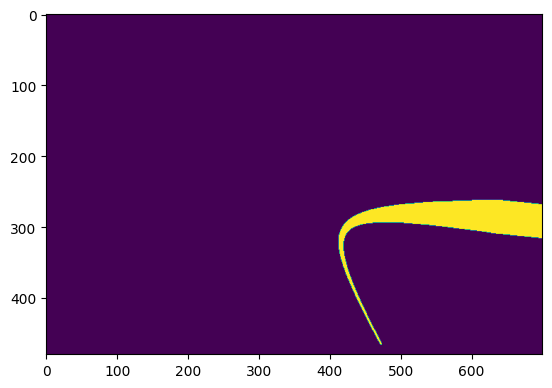

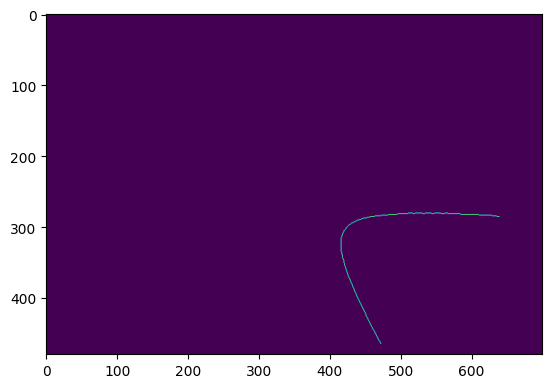

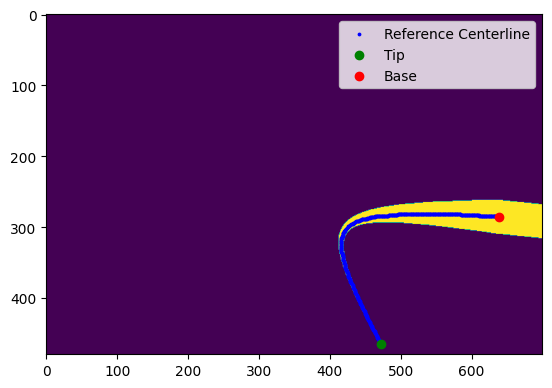

In [28]:
img_ref = img_ref_binary

img_height = img_ref.shape[0]
img_width = img_ref.shape[1]

# perform skeletonization, need to extend the boundary of the image because of the way the skeletonization algorithm works (it looks at the 8 neighbors of each pixel)
extend_dim = int(60)
img_thresh_extend = np.zeros((img_height, img_width + extend_dim))
img_thresh_extend[0:img_height, 0:img_width] = img_ref / 1.0

# get the left boundary of the image
left_boundarylineA_id = np.squeeze(np.argwhere(img_thresh_extend[:, img_width - 1]))
left_boundarylineB_id = np.squeeze(np.argwhere(img_thresh_extend[:, img_width - 10]))

# get the center of the left boundary
extend_vec_pt1_center = np.array([img_width, (left_boundarylineA_id[0] + left_boundarylineA_id[-1]) / 2])
extend_vec_pt2_center = np.array(
    [img_width - 5, (left_boundarylineB_id[0] + left_boundarylineB_id[-1]) / 2])
exten_vec = extend_vec_pt2_center - extend_vec_pt1_center

plt.figure()
plt.imshow(img_thresh_extend)
plt.scatter(extend_vec_pt1_center[0], extend_vec_pt1_center[1], color='green', label='extend_vec_pt1_center', s=5)  
plt.scatter(extend_vec_pt2_center[0], extend_vec_pt2_center[1], color='red', label='extend_vec_pt2_center', s=5)
plt.legend()

# avoid dividing by zero
if exten_vec[1] == 0:
    exten_vec[1] += 0.00000001

# get the slope and intercept of the line
k_extend = exten_vec[0] / exten_vec[1]
b_extend_up = img_width - k_extend * left_boundarylineA_id[0]
b_extend_dw = img_width - k_extend * left_boundarylineA_id[-1]

# extend the ROI to the right, so that the skeletonization algorithm could be able to get the centerline
# then it could be able to get the intersection point with boundary
extend_ROI = np.array([
    np.array([img_width, left_boundarylineA_id[0]]),
    np.array([img_width, left_boundarylineA_id[-1]]),
    np.array([img_width + extend_dim,
                int(((img_width + extend_dim) - b_extend_dw) / k_extend)]),
    np.array([img_width + extend_dim,
                int(((img_width + extend_dim) - b_extend_up) / k_extend)])
])

# fill the extended ROI with 1
img_thresh_extend = cv2.fillPoly(img_thresh_extend, [extend_ROI], 1)

plt.figure()
plt.imshow(img_thresh_extend)

# skeletonize the image
skeleton = skimage_morphology.skeletonize(img_thresh_extend)
skeleton[:, img_width:] = 0

plt.figure()
plt.imshow(skeleton)

# get the centerline of the image
img_raw_skeleton = np.argwhere(skeleton[:, 0:img_width] == 1)

img_raw_skeleton = find_endpoints(skeleton, img_raw_skeleton)

plt.figure()
plt.imshow(img_thresh_extend)
img_raw_skeleton = img_raw_skeleton[:, [1, 0]]
x_centerline = img_raw_skeleton[:, 0]
y_centerline = img_raw_skeleton[:, 1]
tip_coords = img_raw_skeleton[0, :].astype(int)
base_coords = img_raw_skeleton[-1, :].astype(int)
plt.scatter(x_centerline, y_centerline, c='b', s=3, label='Reference Centerline')
plt.scatter(tip_coords[0], tip_coords[1], color='green', label='Tip')  
plt.scatter(base_coords[0], base_coords[1], color='red', label='Base')
plt.legend()